In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

<div dir="rtl">
    به دلیل اینکه در محیط Kaggle در حال توسعه هستم، شکل ورودی ها متفاوت هستند
</div>

In [2]:
train_data_dir = '/kaggle/input/gender-classification-dataset/Training'
val_data_dir = '/kaggle/input/gender-classification-dataset/Validation'

In [3]:
paths_dict = {
    'female': [],
    'male': []
}

In [4]:
for key in paths_dict.keys():
    for dirname, _, filenames in os.walk(os.path.join(train_data_dir, key)):
        for filename in filenames:
            paths_dict[key].append(os.path.join(dirname, filename))

In [5]:
groups = [key + '\n' + str(len(paths_dict[key])) 
          for key in paths_dict.keys()]
count_data = [len(paths_dict[key])
          for key in paths_dict.keys()]
colors = ['b', 'r']

Visualization of the amount of train data in classes

<BarContainer object of 2 artists>

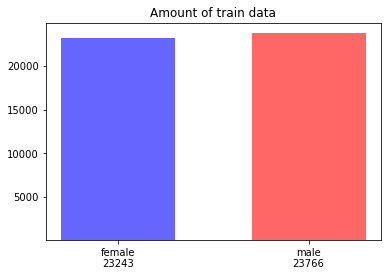

In [6]:
plt.title('Amount of train data')

width = len(count_data) * 0.3
plt.bar(groups, count_data, width=width, color=colors, alpha=0.6, bottom=2, linewidth=2)

Creation of directories for generators

In [7]:
train_dir = '/kaggle/working/train_dir'
test_dir = '/kaggle/working/test_dir'

In [8]:
def create_directory(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)
    
    for key in paths_dict.keys():
        os.makedirs(os.path.join(dir_name, key))

In [9]:
create_directory(train_dir)
create_directory(test_dir)

In [10]:
def copy_images(start_index, end_index, paths, dest_dir):
    for i in range(start_index, end_index):
        dest_path = os.path.join(dest_dir, paths[i].split('/')[5])
        shutil.copy2(paths[i], dest_path)

In [11]:
# Part of the test data set
test_data_proportion = 0.2

In [12]:
for key in paths_dict.keys():
    test_index = len(paths_dict[key]) - int(len(paths_dict[key]) * test_data_proportion)
    
    copy_images(0, test_index, paths_dict[key], train_dir)
    copy_images(test_index, len(paths_dict[key]), paths_dict[key], test_dir)

<div dir="rtl">در اینجا یادگیری انتقالی با استفاده از inception_v3 انجام شده است. هر چند گزینه های متفاوتی برای این کار وجود دارد.</div>

In [13]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

<div dir="rtl">وزن ها نیز از شبکه imagenet گرفته میشود.</div>

In [15]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [16]:
for layer in pre_trained_model.layers:
  layer.trainable = False

<div dir="rtl">مانند تمرین های پیش با قرار دادن این شرط بر روی هر epoch از overfit شدن شبکه جلوگیری میکنیم.</div>

In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.959):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

کراس به صورت پیش فرض این معیارهای سنجش را ندارد. پس ما آنها را اضافه میکنیم.

In [18]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives =K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


<div dir="rtl">در ادامه مدل را با چند گزینه متفاوت تست میکنیم و نتایج را ترسیم میکنیم.</div>

In [19]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(pre_trained_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           
model = Model( pre_trained_model.input, x) 
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc', f1_m, precision_m, recall_m])

In [20]:

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [21]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))
validation_generator =  test_datagen.flow_from_directory( val_data_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 37608 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [23]:
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 5,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

Epoch 1/5
100/100 - 76s - loss: 0.3755 - acc: 0.8495 - f1_m: 0.8407 - precision_m: 0.8472 - recall_m: 0.8549 - val_loss: 0.2280 - val_acc: 0.9130 - val_f1_m: 0.9064 - val_precision_m: 0.9330 - val_recall_m: 0.8886
Epoch 2/5
100/100 - 75s - loss: 0.4001 - acc: 0.8465 - f1_m: 0.8342 - precision_m: 0.8458 - recall_m: 0.8464 - val_loss: 0.2364 - val_acc: 0.9180 - val_f1_m: 0.9213 - val_precision_m: 0.8973 - val_recall_m: 0.9531
Epoch 3/5
100/100 - 76s - loss: 0.3811 - acc: 0.8555 - f1_m: 0.8403 - precision_m: 0.8606 - recall_m: 0.8473 - val_loss: 0.2183 - val_acc: 0.9120 - val_f1_m: 0.9016 - val_precision_m: 0.9598 - val_recall_m: 0.8595
Epoch 4/5
100/100 - 75s - loss: 0.3503 - acc: 0.8580 - f1_m: 0.8512 - precision_m: 0.8642 - recall_m: 0.8562 - val_loss: 0.2710 - val_acc: 0.9020 - val_f1_m: 0.8978 - val_precision_m: 0.9027 - val_recall_m: 0.9044
Epoch 5/5
100/100 - 75s - loss: 0.3992 - acc: 0.8510 - f1_m: 0.8491 - precision_m: 0.8511 - recall_m: 0.8652 - val_loss: 0.3062 - val_acc: 0.878

In [24]:
print("F1-score: ",history.history['f1_m'])
print("F1-score val: ",history.history['val_f1_m'])
print("Precision: ",history.history['precision_m'])
print("Precision val: ",history.history['val_precision_m'])
print("Recall: ",history.history['recall_m'])
print("Recall: ",history.history['val_recall_m'])

F1-score:  [0.8407394289970398, 0.8341829180717468, 0.8402611613273621, 0.8511703014373779, 0.8491050601005554]
F1-score val:  [0.9063559770584106, 0.921322762966156, 0.9015808701515198, 0.8977724313735962, 0.8535948395729065]
Precision:  [0.8472417593002319, 0.8458000421524048, 0.8606016039848328, 0.8642193675041199, 0.8511349558830261]
Precision val:  [0.9330036640167236, 0.8973116874694824, 0.9597756266593933, 0.9027490019798279, 0.9799206256866455]
Recall:  [0.8548954129219055, 0.8463683128356934, 0.8472875356674194, 0.8561524152755737, 0.8651675581932068]
Recall:  [0.8886397480964661, 0.953062891960144, 0.8594872951507568, 0.90435391664505, 0.7706601619720459]


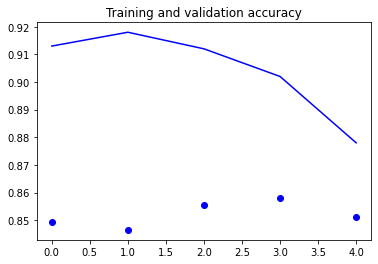

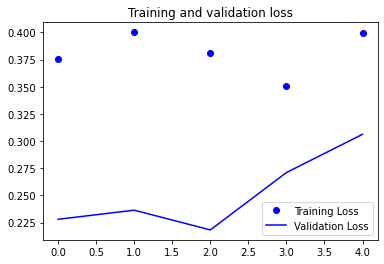

In [25]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
last_layer = pre_trained_model.get_layer('mixed7') #Only use layers including and above 'mixed7'
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [28]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc', f1_m, precision_m, recall_m])

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

validation_generator =  test_datagen.flow_from_directory( val_data_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 5,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

last layer output shape:  (None, 7, 7, 768)
Found 37608 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.
Epoch 1/5
100/100 - 85s - loss: 0.5301 - acc: 0.7680 - f1_m: 0.7449 - precision_m: 0.7868 - recall_m: 0.7738 - val_loss: 1.1455 - val_acc: 0.5960 - val_f1_m: 0.2914 - val_precision_m: 0.8550 - val_recall_m: 0.1849
Epoch 2/5
100/100 - 85s - loss: 0.3782 - acc: 0.8506 - f1_m: 0.8423 - precision_m: 0.8683 - recall_m: 0.8538 - val_loss: 0.2482 - val_acc: 0.9120 - val_f1_m: 0.9020 - val_precision_m: 0.9478 - val_recall_m: 0.8689
Epoch 3/5
100/100 - 84s - loss: 0.3561 - acc: 0.8590 - f1_m: 0.8561 - precision_m: 0.8756 - recall_m: 0.8604 - val_loss: 0.1959 - val_acc: 0.9250 - val_f1_m: 0.9147 - val_precision_m: 0.9632 - val_recall_m: 0.8777
Epoch 4/5
100/100 - 86s - loss: 0.3453 - acc: 0.8540 - f1_m: 0.8449 - precision_m: 0.8612 - recall_m: 0.8575 - val_loss: 0.3431 - val_acc: 0.8630 - val_f1_m: 0.8362 - val_precision_m: 0.9819 - val_recall_m: 0.7376
Epoch 5/5
100/

In [29]:
print("F1-score: ",history.history['f1_m'])
print("F1-score val: ",history.history['val_f1_m'])
print("Precision: ",history.history['precision_m'])
print("Precision val: ",history.history['val_precision_m'])
print("Recall: ",history.history['recall_m'])
print("Recall: ",history.history['val_recall_m'])

F1-score:  [0.7449223399162292, 0.8422620296478271, 0.8561142086982727, 0.8448574542999268, 0.86872398853302]
F1-score val:  [0.29142606258392334, 0.9019697308540344, 0.9147234559059143, 0.8361790180206299, 0.9028476476669312]
Precision:  [0.7867750525474548, 0.8682973980903625, 0.8755972981452942, 0.8611530065536499, 0.8792316913604736]
Precision val:  [0.8550000190734863, 0.9477639198303223, 0.9631639719009399, 0.9818889498710632, 0.9760000109672546]
Recall:  [0.7737969160079956, 0.8537583947181702, 0.8603536486625671, 0.8574993014335632, 0.8770077228546143]
Recall:  [0.184934601187706, 0.8689444661140442, 0.8777315616607666, 0.7375546097755432, 0.8473546504974365]


In [30]:
len_train_data = len(train_generator.filenames)
len_test_data = len(validation_generator.filenames)

result = model.evaluate_generator(validation_generator,
                                  len_test_data // 20,
                                  verbose=1)

582/582 [==============================] - 198s 340ms/step - loss: 0.2543 - acc: 0.9061 - f1_m: 0.8926 - precision_m: 0.9740 - recall_m: 0.8328


In [31]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

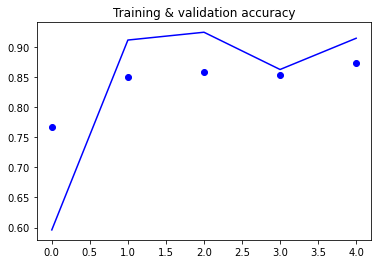

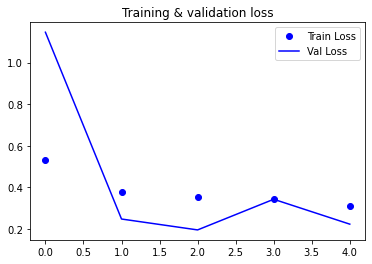

In [32]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train accuracy')
plt.plot(epochs, val_acc, 'b', label='Val accuracy')
plt.title('Training & validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Val Loss')
plt.title('Training & validation loss')
plt.legend()

plt.show()

In [33]:
last_layer = pre_trained_model.get_layer('mixed7') #Only use layers including and above 'mixed7'
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [34]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc', f1_m, precision_m, recall_m])

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

validation_generator =  test_datagen.flow_from_directory( val_data_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 5,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

last layer output shape:  (None, 7, 7, 768)
Found 37608 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.
Epoch 1/5
100/100 - 86s - loss: 0.5552 - acc: 0.7620 - f1_m: 0.7407 - precision_m: 0.7918 - recall_m: 0.7710 - val_loss: 0.2299 - val_acc: 0.9140 - val_f1_m: 0.9111 - val_precision_m: 0.8949 - val_recall_m: 0.9375
Epoch 2/5
100/100 - 85s - loss: 0.3677 - acc: 0.8420 - f1_m: 0.8343 - precision_m: 0.8629 - recall_m: 0.8460 - val_loss: 0.2334 - val_acc: 0.9050 - val_f1_m: 0.9030 - val_precision_m: 0.9382 - val_recall_m: 0.8771
Epoch 3/5
100/100 - 96s - loss: 0.3587 - acc: 0.8525 - f1_m: 0.8481 - precision_m: 0.8633 - recall_m: 0.8649 - val_loss: 0.2304 - val_acc: 0.9260 - val_f1_m: 0.9160 - val_precision_m: 0.9590 - val_recall_m: 0.8845
Epoch 4/5
100/100 - 86s - loss: 0.3159 - acc: 0.8820 - f1_m: 0.8798 - precision_m: 0.8903 - recall_m: 0.8899 - val_loss: 0.1892 - val_acc: 0.9220 - val_f1_m: 0.9231 - val_precision_m: 0.9644 - val_recall_m: 0.8921
Epoch 5/5
100/

In [35]:
print("F1-score: ",history.history['f1_m'])
print("F1-score val: ",history.history['val_f1_m'])
print("Precision: ",history.history['precision_m'])
print("Precision val: ",history.history['val_precision_m'])
print("Recall: ",history.history['recall_m'])
print("Recall: ",history.history['val_recall_m'])

F1-score:  [0.7406851053237915, 0.8342748880386353, 0.8480603098869324, 0.879844069480896, 0.8648518919944763]
F1-score val:  [0.9110618829727173, 0.9030165076255798, 0.9159930348396301, 0.9231345653533936, 0.8851871490478516]
Precision:  [0.7918279767036438, 0.8628731369972229, 0.8632971048355103, 0.8902902007102966, 0.8732530474662781]
Precision val:  [0.8949474096298218, 0.938245952129364, 0.9590448141098022, 0.9643641114234924, 0.9643008708953857]
Recall:  [0.7709531188011169, 0.8460004925727844, 0.864858090877533, 0.8898563981056213, 0.8716673851013184]
Recall:  [0.9374530911445618, 0.8771480321884155, 0.8844830989837646, 0.8920505046844482, 0.832252562046051]


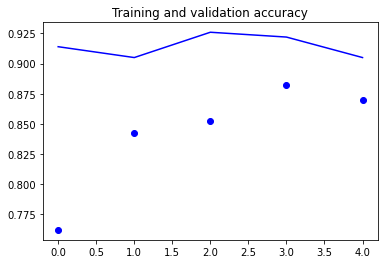

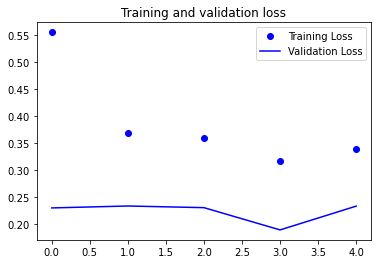

In [36]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
#batch_size = 20

result = model.evaluate_generator(validation_generator,
                                  len_test_data // 20,
                                  verbose=1)

582/582 [==============================] - 196s 338ms/step - loss: 0.2602 - acc: 0.8948 - f1_m: 0.8775 - precision_m: 0.9689 - recall_m: 0.8125


In [38]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________